<a href="https://colab.research.google.com/github/xinruili07/MusicGenreClassifier/blob/master/CNN_Spectrogram_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!mkdir genres
!unzip -q "/content/genres.zip"

mkdir: cannot create directory ‘genres’: File exists


In [3]:
### Importing Libraries

import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

import os
from PIL import Image
from pathlib import Path
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
import keras

Using TensorFlow backend.


In [4]:
import librosa.display

songname = f'./genres/blues/blues.00000.au'
y, sr = librosa.load(songname, mono=True, duration=2, offset=0)
ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512, n_mels=128)
ps = librosa.power_to_db(ps**2)
ps.shape

(128, 173)

In [0]:
dataset = []
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
        'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

for genre, genre_number in genres.items():
    for filename in os.listdir(f'./genres/{genre}'):
        songname = f'./genres/{genre}/{filename}'
        for index in range(14):
            y, sr = librosa.load(songname, mono=True, duration=2, offset=index*2)
            ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512, n_mels=64)
            ps = librosa.power_to_db(ps**2)
            dataset.append( (ps, genre_number) )               

In [7]:
print(len(dataset))

import random

random.shuffle(dataset)

train = dataset[:10000]
valid = dataset[10000:12000]
test = dataset[12000:]

X_train, Y_train = zip(*train)
X_valid, Y_valid = zip(*valid)
X_test, Y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (64, 173, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (64, 173, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (64, 173, 1) ) for x in X_test])

# One-Hot encoding for classes
Y_train = np.array(keras.utils.to_categorical(Y_train, 10))
Y_valid = np.array(keras.utils.to_categorical(Y_valid, 10))
Y_test = np.array(keras.utils.to_categorical(Y_test, 10))


14000


In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import AveragePooling2D

from keras import regularizers

model = Sequential()
input_shape=(64, 173, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 60, 169, 24)       624       
_________________________________________________________________
average_pooling2d_4 (Average (None, 30, 84, 24)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 30, 84, 24)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 84, 48)        28848     
_________________________________________________________________
average_pooling2d_5 (Average (None, 15, 42, 48)        0         
_________________________________________________________________
activation_7 (Activation)    (None, 15, 42, 48)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 15, 42, 48)       

In [23]:
from keras.callbacks import EarlyStopping

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)
hist = model.fit(X_train, Y_train, epochs=90, batch_size=32, validation_data= (X_valid, Y_valid), callbacks=[early_stopping])

Train on 10000 samples, validate on 2000 samples
Epoch 1/90
10000/10000 [==============================] - 7s 746us/step - loss: 2.1673 - acc: 0.2179 - val_loss: 1.7939 - val_acc: 0.3540
Epoch 2/90
10000/10000 [==============================] - 5s 521us/step - loss: 1.7467 - acc: 0.3717 - val_loss: 1.4378 - val_acc: 0.4895
Epoch 3/90
10000/10000 [==============================] - 5s 522us/step - loss: 1.5552 - acc: 0.4568 - val_loss: 1.3099 - val_acc: 0.5470
Epoch 4/90
10000/10000 [==============================] - 5s 500us/step - loss: 1.4397 - acc: 0.5004 - val_loss: 1.2369 - val_acc: 0.5750
Epoch 5/90
10000/10000 [==============================] - 5s 523us/step - loss: 1.3741 - acc: 0.5250 - val_loss: 1.1751 - val_acc: 0.5855
Epoch 6/90
10000/10000 [==============================] - 5s 518us/step - loss: 1.2966 - acc: 0.5572 - val_loss: 1.2102 - val_acc: 0.5935
Epoch 7/90
10000/10000 [==============================] - 5s 516us/step - loss: 1.2292 - acc: 0.5716 - val_loss: 1.1286 - v

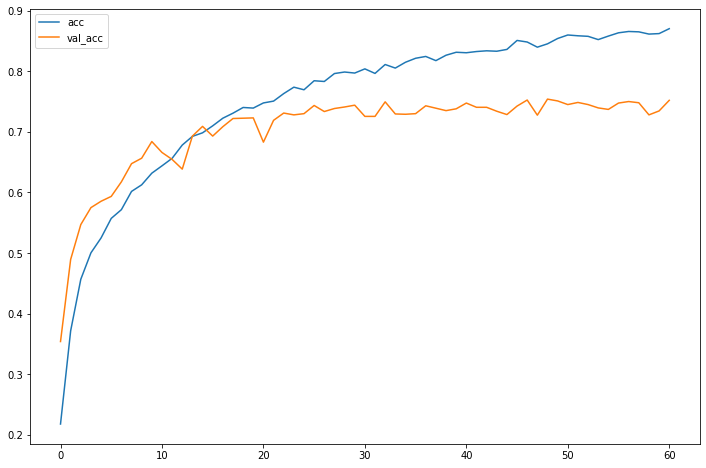

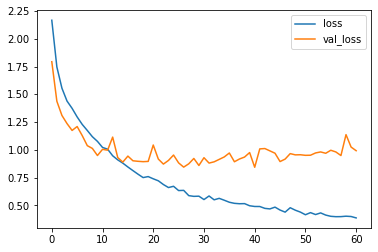

2000/2000 [==============================] - 0s 173us/step
Test loss: 0.8917159118652344
Test accuracy: 0.7685


In [24]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['acc','val_acc'])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])